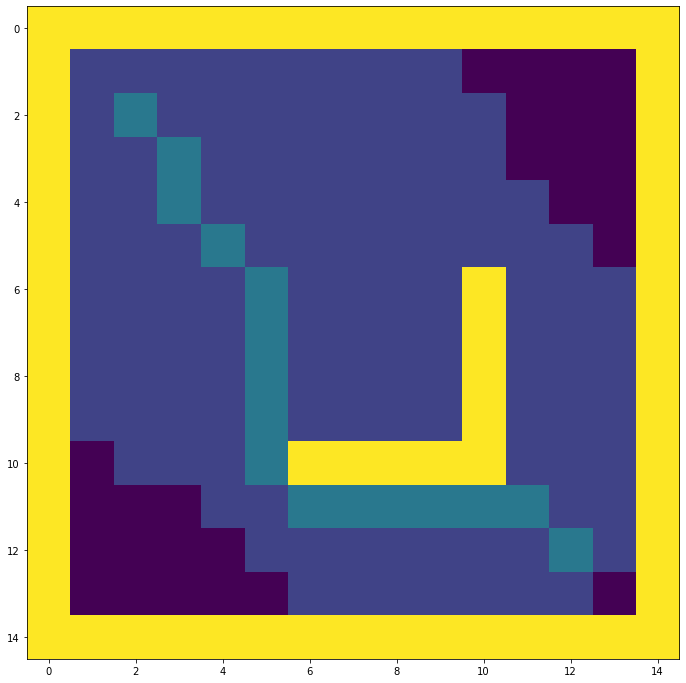

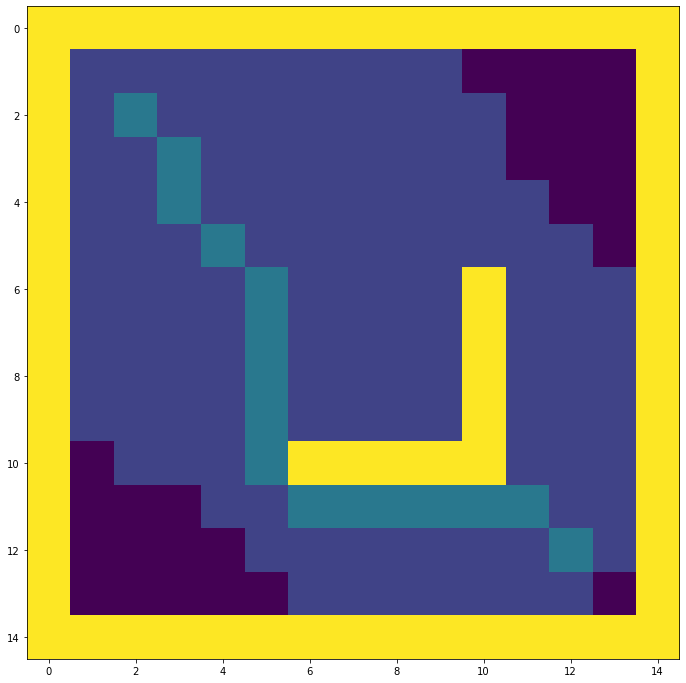

In [12]:
import heapq
import math
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib
%matplotlib inline
#set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.figure(figsize=(12, 12))

"""

"""

class GridMap:
    def __init__(self, ox, oy, resolution):
        self.min_x = None
        self.min_y = None
        self.max_x = None
        self.max_y = None
        self.x_width = None
        self.y_width = None
        self.obstacle_map = None
        
        self.resolution = resolution
        self.calc_obstacle_map(ox, oy)
        
    def calc_obstacle_map(self, ox, oy):

        self.min_x = round(min(ox))
        self.min_y = round(min(oy))
        self.max_x = round(max(ox))
        self.max_y = round(max(oy))
        print("min_x:", self.min_x)
        print("min_y:", self.min_y)
        print("max_x:", self.max_x)
        print("max_y:", self.max_y)

        self.x_width = round((self.max_x - self.min_x) / self.resolution)+1
        self.y_width = round((self.max_y - self.min_y) / self.resolution)+1
        print("x_width:", self.x_width)
        print("y_width:", self.y_width)

        # obstacle map generation
        self.obstacle_map = np.zeros((self.x_width, self.y_width))
        for x, y in zip(ox, oy):
            ix, iy = self.calc_xy_index(x, self.min_x), self.calc_xy_index(y, self.min_y)
            if 0<=ix<self.x_width and 0<=iy<self.y_width:
                self.obstacle_map[ix, iy] = 10.0  
        

    def calc_position(self, index, minp):
        pos = index * self.resolution + minp
        return pos

    def calc_xy_index(self, position, minp):
        return round((position - minp) / self.resolution)
    
    def calc_unique_index(self, node):
        return node.iy*self.x_width + node.ix

    def verify_node(self, node):
        if node.ix >= self.x_width or node.ix < 0 or node.iy >= self.y_width or node.iy < 0:
            return False
        if abs(self.obstacle_map[node.ix, node.iy] - 10.0) < 0.01:
            return False        
        return True

sx = -5.0  # [m]
sy = -5.0  # [m]
gx = 50.0  # [m]
gy = 50.0  # [m]
grid_size = 5.0  # [m]
robot_radius = 1.0  # [m]

# set obstacle positions
ox, oy = [], []
for i in range(-10, 60):
    ox.append(i)
    oy.append(-10.0)
for i in range(-10, 60):
    ox.append(60.0)
    oy.append(i)
for i in range(-10, 61):
    ox.append(i)
    oy.append(60.0)
for i in range(-10, 61):
    ox.append(-10.0)
    oy.append(i)
# for i in range(-10, 40):
#     ox.append(20.0)
#     oy.append(i)
for i in range(20, 40):
    ox.append(40.0)
    oy.append(60.0 - i)    
    
for i in range(20, 40):
    oy.append(40.0)
    ox.append(i)      
grid_map = GridMap(ox, oy, grid_size)



class Node:
    def __init__(self, ix, iy, C=0.0, P=None):
        self.ix = ix
        self.iy = iy
        self.C = C
        self.P = P
        
action_set = {'UP':[0, 1], 'DOWN':[0, -1], 'LEFT':[-1, 0], 'RIGHT':[1, 0], 'UL':[-1, 1], 'UR':[1, 1], 'DL':[-1, -1], 'DR':[1, -1]}

def get_neighbors(current, grid_map):
    for a in action_set:
        node = Node(current.ix+action_set[a][0], 
                    current.iy+action_set[a][1], current.C+np.sqrt(action_set[a][0]*action_set[a][0]+action_set[a][1]*action_set[a][1]), 
                    grid_map.calc_unique_index(current))
        if grid_map.verify_node(node):
            yield node

            
def get_weight(d):
    return np.exp(0.3*d)
def get_heuristic(node, end_node):
    dx = node.ix - end_node.ix
    dy = node.iy - end_node.iy
    d = np.sqrt(dx*dx+dy*dy)
    print(d, get_weight(d))
    return d
        

    
def AStar(grid_map, start_node, end_node):
    Closed_set, Open_set = {}, {}
    Open_set[grid_map.calc_unique_index(start_node)] = start_node
    Q = []
    heapq.heappush(Q, (start_node.C+get_heuristic(start_node, end_node), 
                       grid_map.calc_unique_index(start_node)))
    while True:
        if not Open_set:
            print("Dijkstra Algorithm Finished.")
            return [], [], -1
        
        C, c_id = heapq.heappop(Q)
        
        if c_id in Open_set:
            current = Open_set.pop(c_id)
            Closed_set[c_id] = current
            if current.ix == end_node.ix and current.iy == end_node.iy:
                return ShortestPathFinder(grid_map, Closed_set, end_node)
        else:
            continue
        
        for node in get_neighbors(current, grid_map):
            neighbor_index = grid_map.calc_unique_index(node)
            if neighbor_index in Closed_set: continue
            if neighbor_index not in Open_set or Open_set[neighbor_index].C > node.C:
                Open_set[neighbor_index] = node
                heapq.heappush(Q, (node.C+get_heuristic(node, end_node), neighbor_index))
                grid_map.obstacle_map[node.ix, node.iy] = 2
        plt.clf()
        plt.imshow(grid_map.obstacle_map)
        if is_ipython:
            display.clear_output(wait=True)
            display.display(plt.gcf())        
            
        
def ShortestPathFinder(grid_map, Closed_set, end_node):
    if grid_map.verify_node(end_node) == False:
        print("the goal is unreachable!!!please change a reachable goal...")
        return [], [], -1
    
    end_index = grid_map.calc_unique_index(end_node)
    SPath_x = [Closed_set[end_index].ix]
    SPath_y = [Closed_set[end_index].iy]      
    SPath_dist = Closed_set[end_index].C*grid_map.resolution
    v_index = Closed_set[end_index].P
    while v_index: 
        SPath_x.append(Closed_set[v_index].ix)
        SPath_y.append(Closed_set[v_index].iy)
        v_index = Closed_set[v_index].P
    return list(reversed(SPath_x)), list(reversed(SPath_y)), SPath_dist

start_node = Node(2, 2)
end_node = Node(12, 12)
grid_map.obstacle_map[start_node.ix, start_node.iy] = 8
grid_map.obstacle_map[end_node.ix, end_node.iy] = 3
plt.imshow(grid_map.obstacle_map)

path_x, path_y, path_dist = AStar(grid_map, start_node, end_node)
grid_map.obstacle_map[end_node.ix, end_node.iy] = 4
for ix, iy in zip(path_x, path_y):
    grid_map.obstacle_map[ix, iy] = 4
    
plt.clf()
plt.imshow(grid_map.obstacle_map)
if is_ipython:
    display.clear_output(wait=True)
    display.display(plt.gcf()) 